In [1]:
import numpy as np
from keras.datasets import mnist
import tensorflow as tf

In [2]:
# MNIST dataset parameters
num_classes = 10 # total classes (0-9 digits)
num_features = 784 # data features (img shape: 28*28)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Convert to float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Flatten images to 1-D vector of 784 features (28*28)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Normalize images value from [0, 255] to [0, 1]
x_train, x_test = x_train / 255., x_test / 255.

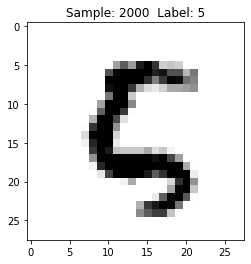

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

def display_sample(num):
    #Print this sample's label 
    label = y_train[num] 
    
    #Reshape the 784 values to a 28x28 image
    image = x_train[num].reshape([28,28])
    plt.title('Sample: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()
    
display_sample(2000)

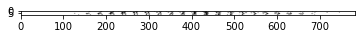

In [4]:
images = x_train[0].reshape([1, 784])
for i in range(1, 10):
    images = np.concatenate((images, x_train[i].reshape([1, 784])))  
plt.imshow(images, cmap=plt.get_cmap('gray_r'))
plt.show()

In [5]:
# Training parameters.
learning_rate = 0.001
training_steps = 3000     #The epoch value basically
batch_size = 250          #No. of samples in one batch
display_step = 100        #Display the change in the neural network or how much it has converged after 100 steps

# Network parameters.
n_hidden = 512 # Number of neurons.

In [6]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))             
train_data = train_data.repeat().shuffle(60000).batch(batch_size).prefetch(1)

In [7]:
# Store layers weight & bias

# A random value generator to initialize weights initially
random_normal = tf.initializers.RandomNormal()

weights = {
    'h': tf.Variable(random_normal([num_features, n_hidden])),    
    #the above function will create 784 variables that contain the weights of the hidden layer 
    'out': tf.Variable(random_normal([n_hidden, num_classes]))
    #need a set of 10 output variables for our output neurons
}
biases = {
    'b': tf.Variable(tf.zeros([n_hidden])),
    #we need 512 variables to create biases 
    'out': tf.Variable(tf.zeros([num_classes]))
    #we also have biases associated with our output layer having 10 variable 
    #by default we want our biases should be zero
}

In [8]:
# Create model.
def neural_net(inputData):
    #here we basically mdo matrix multiplication of the 714 pixel values with the biases
    #we then add the product matrix with the bias matrix
    
    hidden_layer = tf.add(tf.matmul(inputData, weights['h']), biases['b'])
    
    # Apply sigmoid to hidden_layer output for non-linearity.
    #here sigmoid is acting as an activation function
    
    hidden_layer = tf.nn.sigmoid(hidden_layer)
    
    #we do the same to our output layer matrix multiplication of hidden layer abd output weights
    #add the output bias matrix to the product matrix that we get
    # Output fully connected layer with a neuron for each class.
    
    out_layer = tf.matmul(hidden_layer, weights['out']) + biases['out']
    
    # Apply softmax to normalize the logits to a probability distribution.
    
    return tf.nn.softmax(out_layer)

In [9]:
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)
    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred))) ########## Do not understand this ##########

In [10]:
optimizer = tf.keras.optimizers.SGD(learning_rate)

def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = neural_net(x)
        loss = cross_entropy(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = list(weights.values()) + list(biases.values())

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [11]:
# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [12]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x)                  #After every 100 cycle the data is fed to the neural network  
        loss = cross_entropy(pred, batch_y)         #loss here represents the accuracy and using cross_entropy function we can also penalize the wrong values
        acc = accuracy(pred, batch_y)               #finds accuracy of the test data   
        print("Training epoch: %i, Loss: %f, Accuracy: %f" % (step, loss, acc))

Training epoch: 100, Loss: 154.831573, Accuracy: 0.828000
Training epoch: 200, Loss: 122.102844, Accuracy: 0.856000
Training epoch: 300, Loss: 110.032707, Accuracy: 0.900000
Training epoch: 400, Loss: 88.254623, Accuracy: 0.904000
Training epoch: 500, Loss: 97.741333, Accuracy: 0.880000
Training epoch: 600, Loss: 70.574760, Accuracy: 0.896000
Training epoch: 700, Loss: 96.237183, Accuracy: 0.892000
Training epoch: 800, Loss: 76.956558, Accuracy: 0.904000
Training epoch: 900, Loss: 68.374893, Accuracy: 0.920000
Training epoch: 1000, Loss: 84.769165, Accuracy: 0.928000
Training epoch: 1100, Loss: 76.046646, Accuracy: 0.912000
Training epoch: 1200, Loss: 79.408707, Accuracy: 0.892000
Training epoch: 1300, Loss: 82.823547, Accuracy: 0.900000
Training epoch: 1400, Loss: 49.641277, Accuracy: 0.936000
Training epoch: 1500, Loss: 46.234005, Accuracy: 0.936000
Training epoch: 1600, Loss: 65.429962, Accuracy: 0.932000
Training epoch: 1700, Loss: 71.820282, Accuracy: 0.916000
Training epoch: 1800

In [13]:
# Test model on validation set.
pred = neural_net(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.932300


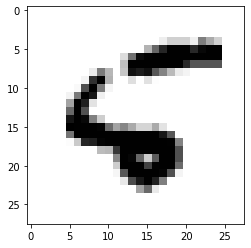

Original Labels: 5
Model prediction: 6


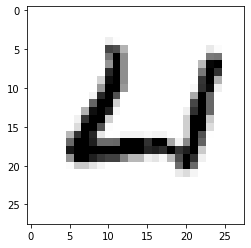

Original Labels: 4
Model prediction: 6


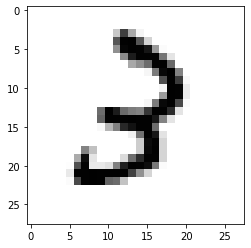

Original Labels: 3
Model prediction: 2


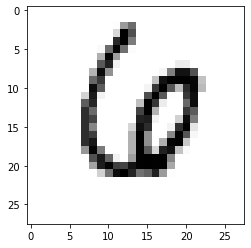

Original Labels: 6
Model prediction: 2


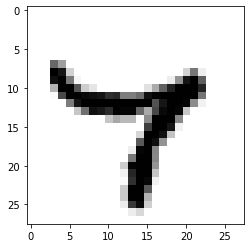

Original Labels: 7
Model prediction: 4


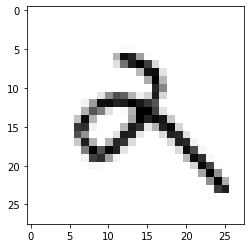

Original Labels: 2
Model prediction: 9


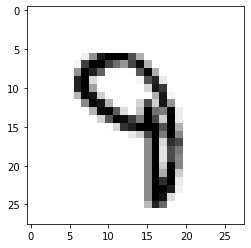

Original Labels: 9
Model prediction: 4


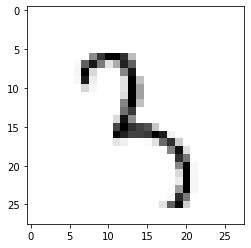

Original Labels: 3
Model prediction: 5


In [14]:
n_images = 200
test_images = x_test[:n_images]
test_labels = y_test[:n_images]
predictions = neural_net(test_images)

for i in range(n_images):
    model_prediction = np.argmax(predictions.numpy()[i])
    if (model_prediction != test_labels[i]):
        plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray_r')
        plt.show()
        print("Original Labels: %i" % test_labels[i])
        print("Model prediction: %i" % model_prediction)